# LLM을 이용한 객관식 질문(MCQ, Multiple Choice Questions) 생성기

MCQ (Multiple Choice Questions) 생성기는 **객관식(다지선다)** 형태의 질문을 자동으로 생성해주는 도구 또는 소프트웨어를 말합니다.   
MCQ 생성기는 주로 교육 분야, 퀴즈 생성, 설문조사, 온라인 테스트 등에서 활용되며, 텍스트를 분석해 효과적으로 여러 선택지를 갖는 질문을 만들어줍니다. 

### MCQ 생성 example

- 주어진 텍스트
```
감성 거래는 시장의 다른 거래자나 투자자의 감정과 의견을 바탕으로 거래하는 것입니다. 
이 전략에는 소셜 미디어 게시물, 뉴스 기사, 분석가 보고서 등 시장 심리의 다양한 소스를 분석하여
특정 자산이나 시장에 대한 전반적인 심리를 측정하는 작업이 포함됩니다.
```

- LLM을 이용한 MCQ 생성
```
question: 감성 거래란 무엇인가요?
choices: A) 시장 심리에 기초한 거래 전략.,B) 기술적 분석에 기초한 거래 전략.,C) 기본적 분석에 기초한 거래 전략.,D) 무작위 추측에 기초한 거래 전략. 
answer: A) 시장 정서에 기초한 거래 전략
```

In [1]:
# 주어진 텍스트
text = """
감성 거래는 시장의 다른 거래자나 투자자의 감정과 의견을 바탕으로 거래하는 것입니다. 
이 전략에는 소셜 미디어 게시물, 뉴스 기사, 분석가 보고서 등 시장 심리의 다양한 소스를 분석하여 
특정 자산이나 시장에 대한 전반적인 심리를 측정하는 작업이 포함됩니다.
"""

# LLM을 이용한 MCQ 생성
"""
question: 감성 거래란 무엇인가요?
choices: A) 시장 심리에 기초한 거래 전략.,B) 기술적 분석에 기초한 거래 전략.,C) 기본적 분석에 기초한 거래 전략.,D) 무작위 추측에 기초한 거래 전략. 
answer: A) 시장 정서에 기초한 거래 전략
"""
None

## 작업 순서
1) PDF Document Load
2) Documents를 Chunk로 변환
3) Text Embedding 생성
4) vector DB로 저장
5) 답변 검색
6) Output을 구조화

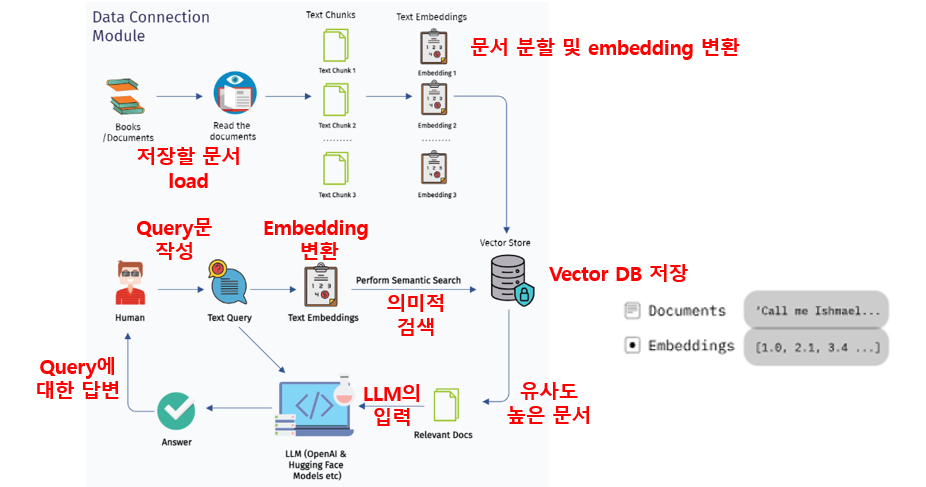

In [2]:
# read local .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv()) 

True

In [3]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

## 1) DB에 저장할 Document Load

`PyPDFDirectoryLoader`를 사용하여 디렉토리에서 사용 가능한 PDF 파일을 로드합니다.

In [4]:
# 문서를 읽는 함수 정의
def load_docs(directory):
    loader = PyPDFDirectoryLoader(directory)
    documents = loader.load()   # 로더를 사용하여 문서 로드
    return documents

# 디렉토리를 'load_docs' 함수에 전달
directory = 'docs_kor/'
documents = load_docs(directory)
len(documents)

14

In [5]:
# load된 pdf 문서
# documents

## Document 변환

### 1. 문서를 더 작은 덩어리(chunk)로 분할<font>

In [6]:
# RecursiveCharacterTextSplitter를 초기화하여 텍스트를 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,       # 각 청크의 최대 크기 설정
    chunk_overlap=20       # 청크 간의 중첩 크기 설정
)
# 문서를 분할하여 청크 리스트 생성
all_splits = text_splitter.split_documents(documents)

print(len(all_splits))

18


In [7]:
# chunk로 분할된 문서
# all_splits

### 2. Text를 Embedding으로 변환

<font color='green'>
문서/텍스트용 임베딩 생성을 위한 OpenAI LLM<font>

In [8]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

<font color='green'>
샘플 텍스트에 대한 임베딩 모델을 테스트해 보겠습니다.<font>

In [9]:
# "안녕 친구"라는 질문을 단어 임베딩으로 변환
query_result = embeddings.embed_query("안녕, 친구")
print("Vector Dimension =", len(query_result))   # index 생성에 사용할 vector dimension
print(query_result[:10])

Vector Dimension = 1536
[-0.011086903512477875, -0.014782538637518883, -0.0552099235355854, 0.01907029189169407, 0.023888908326625824, -0.024052251130342484, -0.03083098493516445, 0.010892934165894985, -0.026277799159288406, -0.010525412857532501]


## LangChain의 VectorStore를 이용한 embedding 저장

In [10]:
from langchain_chroma import Chroma

# Chroma 벡터 스토어 초기화
vector_store = Chroma(embedding_function=embeddings)
vector_store

In [11]:
# 문서들을 벡터 스토어에 추가하고, 생성된 ID 반환
ids = vector_store.add_documents(documents=all_splits)
ids[:5]

['d11e6c82-ea6e-4870-95a9-66d6d3dfe607',
 'f8a40a39-6961-4fa6-a190-a490f333bcbb',
 '5ec34e52-2973-48f1-ab63-585b9e7a51ab',
 'a2503af5-1d07-4c43-973c-8bb20b948f40',
 '6021b524-abda-4eb3-94f0-bb9d26ea617b']

### MCQ 문제를 생성할 query 문

In [12]:
our_query = "시계열 데이터의 정상성이란 무었인가?"
#our_query = "귀무가설이란 무었인가?"

In [13]:
retriever = vector_store.as_retriever(
    search_type="similarity",  # 유사도 검색
    search_kwargs={"k": 2}    # 검색 결과로 반환되는 문서의 수
)  

# 입력 쿼리와 가장 관련성이 높은 문서를 검색
retrieved = retriever.get_relevant_documents(our_query)
retrieved

C:\Users\trimu\AppData\Local\Temp\ipykernel_10352\1214636763.py:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved = retriever.get_relevant_documents(our_query)


[Document(metadata={'page': 9, 'source': 'docs_kor\\파이썬금융분석.pdf'}, page_content='시계열 데이터 처리에서의 정상성\n(stationarity)의 중요성 \n \n정상성은 전통적인 시계열 분석에서 중요한 개념이며 시계열 모델링을 위한 머신 러닝 \n모델의 성능에 영향을 미칠 수 있습니다. \n통계학적 기법들은 모두 시계열 데이터의 정상성을 전제로 하고 있습니다. 평균 및 분산과 같은 \n통계학적 속성이 시간 경과에 무관하게 일정하므로 패턴을 모델링하고 미래 값을 예측하기가 더 \n쉽습니다. 반면 비정상 시계열은 시간이 지남에 따라 통계적 특성이 변하므로 모델링 및 예측이 \n더 어려울 수 있습니다. \n심층 신경망의 경우에도 정상성은 모델의 안정성과 예측 정확도에 영향을 줄 수 있으므로 여전히 \n중요한 고려 사항입니다. 그러나 복잡한 표현을 학습하는 심층 신경망의 능력은 종종 비정상성으\n로 인한 문제를 어느 정도 극복할 수 있습니다. \n따라서 심층 신경망을 사용하기 전에 시계열 데이터의 정상성을 확인하고 그에 따라 사전 처리하\n는 것이 좋습니다. 시계열을 정상 상태로 만드는 가장 일반적인 방법은 추세와 계절성을 제거하\n는 것입니다. 제거 방법은 뒤에서 자세히 설명 하겠습니다. \n시계열 데이터에 대한 일반적인 접근법은 다음과 같습니다. \n1 단계 : 시계열 데이터의 정상성을 체크하고 비정상(non-stationary) 데이터의 경우 2 단계 이\n후를 실행합니다. \n2 단계 : 시계열 데이터에 다음 사항 적용 \n⚫ 추세(trend)를 제거하여 평균값을 일정하게 만듭니다. \n⚫ 이분산성(heteroscedasticity)을 제거하여 분산을 일정하게 만듭니다. \n⚫ 자기상관성(autocorrelation)을 제거 합니다. \n⚫ 계절성(seasonality)을 제거 합니다. \n3 단계 : 위에서 얻어진 정상 시계열을 이용하여 머신 러닝 모델을 구축 합니다. \n \n그러면 구체적으로 

## 출력 형태 구조화

In [14]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
import re
import json

# 응답 스키마 정의
# 각 스키마는 'name'과 'description'으로 구성되며, 이는 생성된 질문, 선택지, 정답에 대한 설명을 포함합니다.
response_schemas = [
    ResponseSchema(name="question", description="제공된 입력 텍스트 데이터에서 생성된 질문."),
    ResponseSchema(name="choices", description="쉼표로 구분된 객관식 질문에 사용 가능한 옵션입니다."),
    ResponseSchema(name="answer", description="질문에 대한 정답입니다.")
]

# 정의된 응답 스키마를 기반으로 구조화된 출력 파서를 생성
# StructuredOutputParser는 LLM의 출력을 구조화된 형태로 파싱하는 데 사용
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
output_parser

StructuredOutputParser(response_schemas=[ResponseSchema(name='question', description='제공된 입력 텍스트 데이터에서 생성된 질문.', type='string'), ResponseSchema(name='choices', description='쉼표로 구분된 객관식 질문에 사용 가능한 옵션입니다.', type='string'), ResponseSchema(name='answer', description='질문에 대한 정답입니다.', type='string')])

In [15]:
# 모델이 출력을 생성할 때 따라야 할 형식 지침을 문자열로 반환합니다.
format_instructions = output_parser.get_format_instructions()

print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"question": string  // 제공된 입력 텍스트 데이터에서 생성된 질문.
	"choices": string  // 쉼표로 구분된 객관식 질문에 사용 가능한 옵션입니다.
	"answer": string  // 질문에 대한 정답입니다.
}
```


In [16]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

아래 스니펫은 응답 형식을 지정하는 방법에 대한 지침이 포함된 문자열을 제공한 다음 이를 프롬프트에 삽입합니다.

In [17]:
# ChatPromptTemplate 생성
# messages 매개변수에는 HumanMessagePromptTemplate을 사용하여 사용자 메시지 템플릿 정의
prompt = ChatPromptTemplate(
    messages=[
        HumanMessagePromptTemplate.from_template(
            """
            사용자가 텍스트를 입력하면 정답과 함께 객관식 질문을 생성하세요.
            {format_instructions}
            {user_prompt}
            """
        )
    ],
    input_variables=["user_prompt"],  # 사용자 입력 변수
    partial_variables={"format_instructions": format_instructions}  # 사전 정의된 형식 지침
)

# 생성된 프롬프트 객체 확인
prompt

ChatPromptTemplate(input_variables=['user_prompt'], input_types={}, partial_variables={'format_instructions': 'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"question": string  // 제공된 입력 텍스트 데이터에서 생성된 질문.\n\t"choices": string  // 쉼표로 구분된 객관식 질문에 사용 가능한 옵션입니다.\n\t"answer": string  // 질문에 대한 정답입니다.\n}\n```'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_instructions', 'user_prompt'], input_types={}, partial_variables={}, template='\n            사용자가 텍스트를 입력하면 정답과 함께 객관식 질문을 생성하세요.\n            {format_instructions}\n            {user_prompt}\n            '), additional_kwargs={})])

- chat_model 에 제공할 prompt 생성

In [18]:
# chat_model 에 제공할 prompt format
final_query = prompt.format_prompt(user_prompt = retrieved).to_messages()
final_query

[HumanMessage(content='\n            사용자가 텍스트를 입력하면 정답과 함께 객관식 질문을 생성하세요.\n            The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"question": string  // 제공된 입력 텍스트 데이터에서 생성된 질문.\n\t"choices": string  // 쉼표로 구분된 객관식 질문에 사용 가능한 옵션입니다.\n\t"answer": string  // 질문에 대한 정답입니다.\n}\n```\n            [Document(metadata={\'page\': 9, \'source\': \'docs_kor\\\\파이썬금융분석.pdf\'}, page_content=\'시계열 데이터 처리에서의 정상성\\n(stationarity)의 중요성 \\n \\n정상성은 전통적인 시계열 분석에서 중요한 개념이며 시계열 모델링을 위한 머신 러닝 \\n모델의 성능에 영향을 미칠 수 있습니다. \\n통계학적 기법들은 모두 시계열 데이터의 정상성을 전제로 하고 있습니다. 평균 및 분산과 같은 \\n통계학적 속성이 시간 경과에 무관하게 일정하므로 패턴을 모델링하고 미래 값을 예측하기가 더 \\n쉽습니다. 반면 비정상 시계열은 시간이 지남에 따라 통계적 특성이 변하므로 모델링 및 예측이 \\n더 어려울 수 있습니다. \\n심층 신경망의 경우에도 정상성은 모델의 안정성과 예측 정확도에 영향을 줄 수 있으므로 여전히 \\n중요한 고려 사항입니다. 그러나 복잡한 표현을 학습하는 심층 신경망의 능력은 종종 비정상성으\\n로 인한 문제를 어느 정도 극복할 수 있습니다. \\n따라서 심층 신경망을 사용하기 전에 시계열 데이터의 정상성을 확인하고 그에 따라 사전 처리하\\n는 것이 좋습니다. 시

In [19]:
final_query_output = chat_model.invoke(final_query)
print(final_query_output.content)

```json
{
	"question": "시계열 데이터에서 정상성의 중요성은 무엇인가?",
	"choices": "모델의 성능 향상, 데이터의 비정상성 무시, 예측의 정확도 저하, 시계열 데이터의 수집 용이성",
	"answer": "모델의 성능 향상"
}
```
